initial version

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 22.5755, Train Acc: 0.4375, Val Loss: 8.4242, Val Acc: 0.4958
Epoch 2, Train Loss: 14.6130, Train Acc: 0.6661, Val Loss: 6.1628, Val Acc: 0.7375
Epoch 3, Train Loss: 10.8351, Train Acc: 0.7786, Val Loss: 6.6319, Val Acc: 0.7625
Epoch 4, Train Loss: 9.7826, Train Acc: 0.8018, Val Loss: 8.7105, Val Acc: 0.7042
Epoch 5, Train Loss: 10.9445, Train Acc: 0.7821, Val Loss: 6.1103, Val Acc: 0.7958
Epoch 6, Train Loss: 7.6799, Train Acc: 0.8482, Val Loss: 4.9715, Val Acc: 0.8000
Epoch 7, Train Loss: 6.4581, Train Acc: 0.8500, Val Loss: 7.0041, Val Acc: 0.7833
Epoch 8, Train Loss: 7.1039, Train Acc: 0.8500, Val Loss: 7.4970, Val Acc: 0.7583
Epoch 9, Train Loss: 6.4962, Train Acc: 0.8696, Val Loss: 5.1687, Val Acc: 0.8417
Epoch 10, Train Loss: 5.7969, Train Acc: 0.8732, Val Loss: 4.6613, Val Acc: 0.8333
Epoch 11, Train Loss: 4.8714, Train Acc: 0.9161, Val Loss: 4.4435, Val Acc: 0.8250
Epoch 12, Train Loss: 4.83

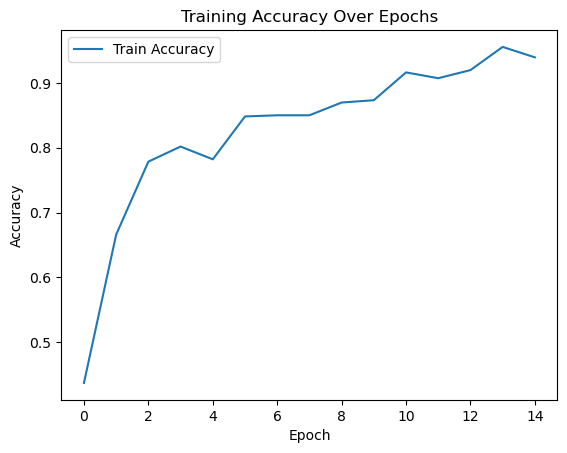

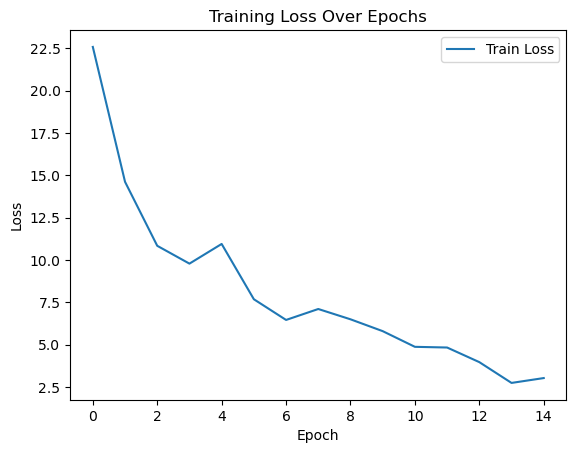

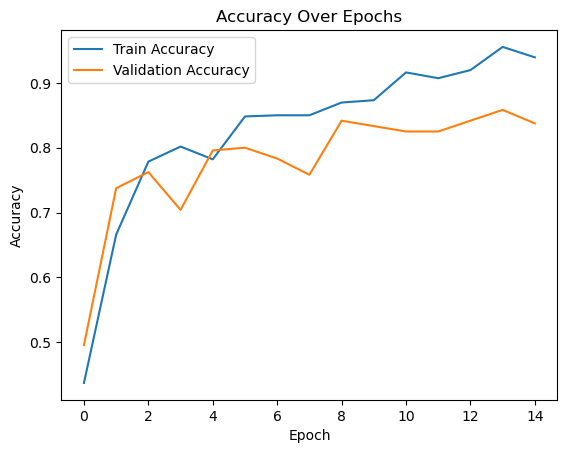

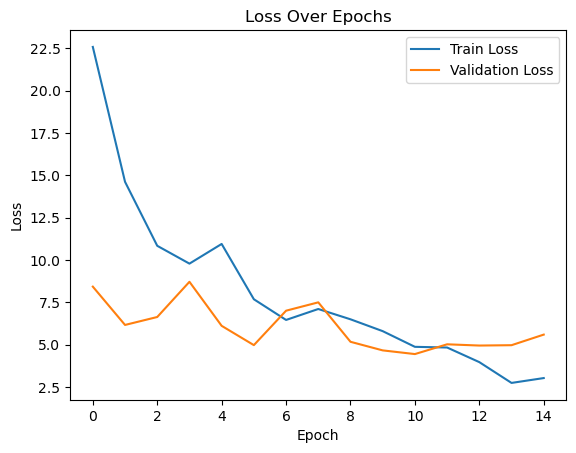

In [3]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name):
    if name.lower() == "relu":
        return nn.ReLU()
    elif name.lower() == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.01)
    elif name.lower() == "gelu":
        return nn.GELU()
    elif name.lower() == "elu":
        return nn.ELU(alpha=1.0)
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout = 0.3):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation),
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='relu',dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


experiment1:use leakyrelu,negative_slope=0.01，droupout=0.3

In [2]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='leakyrelu',dropout=0.3,negative_slope=0.01).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps


KeyboardInterrupt: 

experiment2:use leakyrelu,negative_slope=0.01，droupout=0.5

In [ ]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='leakyrelu',dropout=0.5,negative_slope=0.01).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment3:use leakyrelu,negative_slope=0.1，droupout=0.3

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 20.5145, Train Acc: 0.4875, Val Loss: 6.9551, Val Acc: 0.7417
Epoch 2, Train Loss: 13.6885, Train Acc: 0.7196, Val Loss: 4.9515, Val Acc: 0.7542
Epoch 3, Train Loss: 10.1091, Train Acc: 0.7946, Val Loss: 4.5236, Val Acc: 0.7667
Epoch 4, Train Loss: 9.4503, Train Acc: 0.7964, Val Loss: 4.6308, Val Acc: 0.8083
Epoch 5, Train Loss: 7.7833, Train Acc: 0.8321, Val Loss: 4.0826, Val Acc: 0.8458
Epoch 6, Train Loss: 6.6505, Train Acc: 0.8571, Val Loss: 3.6528, Val Acc: 0.8625
Epoch 7, Train Loss: 6.0958, Train Acc: 0.8893, Val Loss: 3.9856, Val Acc: 0.8167
Epoch 8, Train Loss: 5.0043, Train Acc: 0.9161, Val Loss: 4.0920, Val Acc: 0.8583
Epoch 9, Train Loss: 4.9816, Train Acc: 0.9036, Val Loss: 4.2308, Val Acc: 0.8542
Epoch 10, Train Loss: 4.5794, Train Acc: 0.9143, Val Loss: 3.5616, Val Acc: 0.8542
Epoch 11, Train Loss: 4.7925, Train Acc: 0.9071, Val Loss: 3.8509, Val Acc: 0.8458
Epoch 12, Train Loss: 3.655

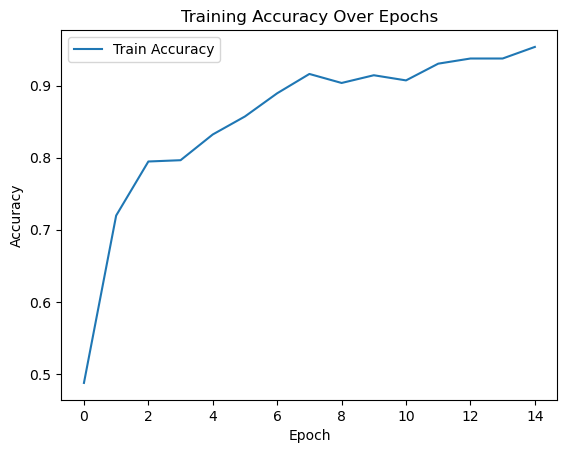

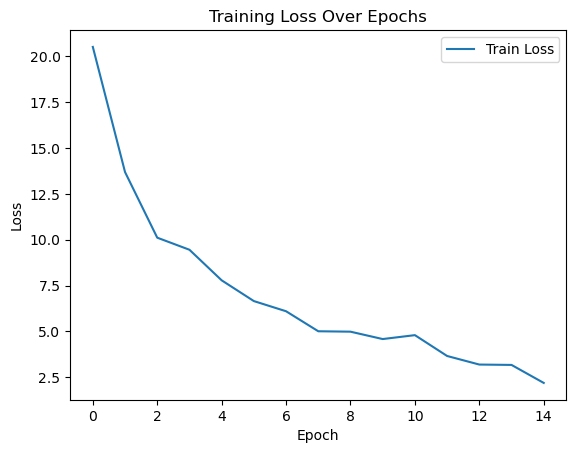

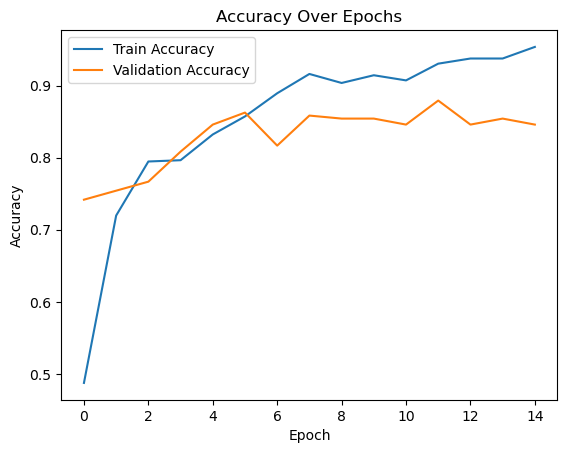

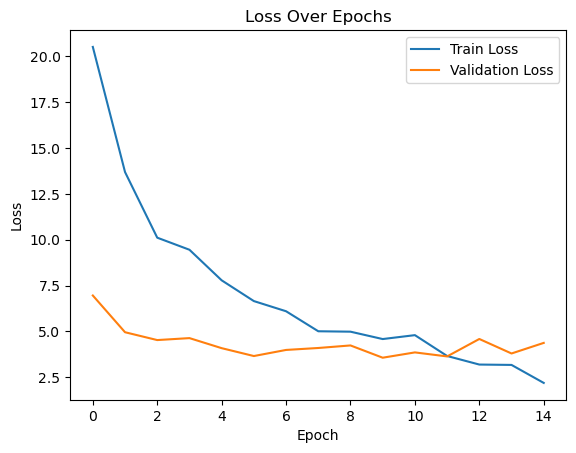

In [5]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='leakyrelu',dropout=0.3,negative_slope=0.1).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment4:use leakyrelu,negative_slope=0.1，droupout=0.3

experiment3:use leakyrelu,negative_slope=0.001，dropout=0.3

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 23.5505, Train Acc: 0.4071, Val Loss: 8.3799, Val Acc: 0.5375
Epoch 2, Train Loss: 16.8864, Train Acc: 0.6518, Val Loss: 6.2839, Val Acc: 0.6875
Epoch 3, Train Loss: 12.1824, Train Acc: 0.7679, Val Loss: 4.6626, Val Acc: 0.7875
Epoch 4, Train Loss: 11.5855, Train Acc: 0.7750, Val Loss: 3.8937, Val Acc: 0.8375
Epoch 5, Train Loss: 10.3093, Train Acc: 0.8196, Val Loss: 4.1849, Val Acc: 0.8083
Epoch 6, Train Loss: 8.1270, Train Acc: 0.8607, Val Loss: 3.2573, Val Acc: 0.8333
Epoch 7, Train Loss: 7.0704, Train Acc: 0.8750, Val Loss: 3.4057, Val Acc: 0.8333
Epoch 8, Train Loss: 5.8726, Train Acc: 0.9000, Val Loss: 4.2296, Val Acc: 0.8083
Epoch 9, Train Loss: 5.4576, Train Acc: 0.8982, Val Loss: 3.2652, Val Acc: 0.8208
Epoch 10, Train Loss: 4.8267, Train Acc: 0.9054, Val Loss: 3.3144, Val Acc: 0.8625
Epoch 11, Train Loss: 4.5240, Train Acc: 0.9089, Val Loss: 3.5531, Val Acc: 0.8500
Epoch 12, Train Loss: 4.5

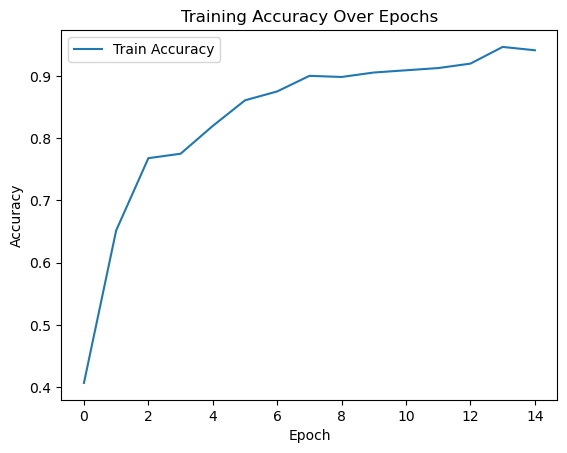

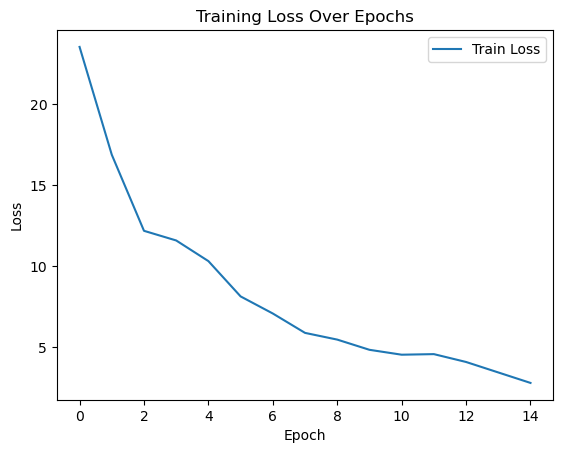

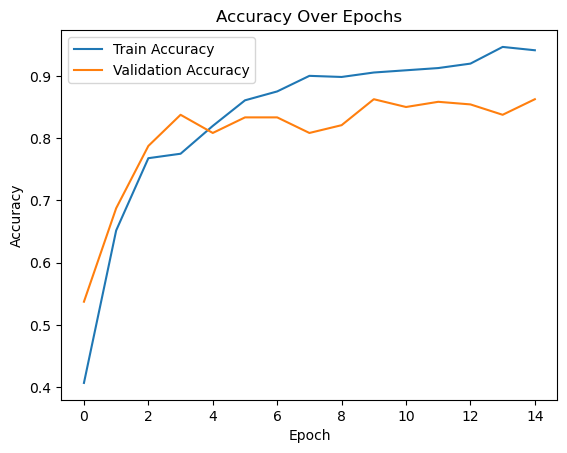

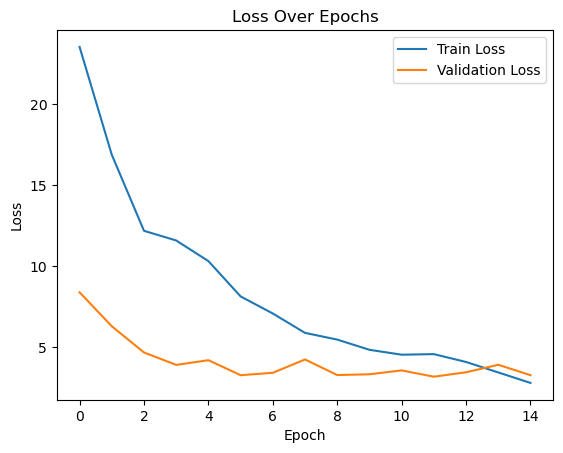

In [6]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='leakyrelu',dropout=0.3,negative_slope=0.001).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment5:use gelu,dropout=0.3

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 19.6688, Train Acc: 0.5214, Val Loss: 6.8098, Val Acc: 0.6500
Epoch 2, Train Loss: 14.1408, Train Acc: 0.7018, Val Loss: 6.1757, Val Acc: 0.7167
Epoch 3, Train Loss: 11.6467, Train Acc: 0.7250, Val Loss: 5.4163, Val Acc: 0.7500
Epoch 4, Train Loss: 11.1635, Train Acc: 0.7714, Val Loss: 6.5826, Val Acc: 0.6833
Epoch 5, Train Loss: 9.6778, Train Acc: 0.7875, Val Loss: 4.9741, Val Acc: 0.7458
Epoch 6, Train Loss: 9.0523, Train Acc: 0.7964, Val Loss: 5.3261, Val Acc: 0.7708
Epoch 7, Train Loss: 7.4844, Train Acc: 0.8536, Val Loss: 4.9376, Val Acc: 0.7917
Epoch 8, Train Loss: 7.4079, Train Acc: 0.8554, Val Loss: 4.4664, Val Acc: 0.8125
Epoch 9, Train Loss: 5.8541, Train Acc: 0.8821, Val Loss: 5.3505, Val Acc: 0.7958
Epoch 10, Train Loss: 4.9604, Train Acc: 0.8964, Val Loss: 5.2475, Val Acc: 0.8208
Epoch 11, Train Loss: 4.9460, Train Acc: 0.9071, Val Loss: 6.3699, Val Acc: 0.7750
Epoch 12, Train Loss: 4.88

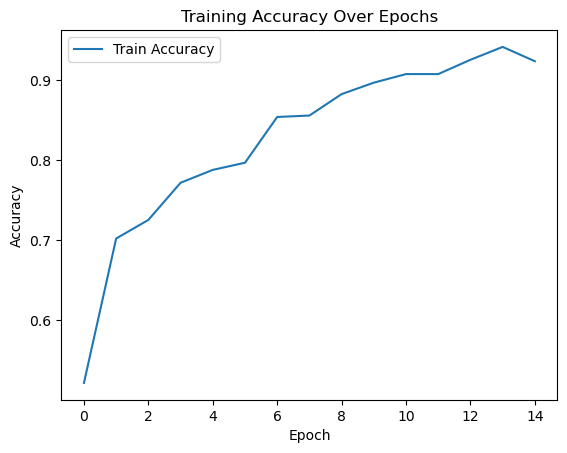

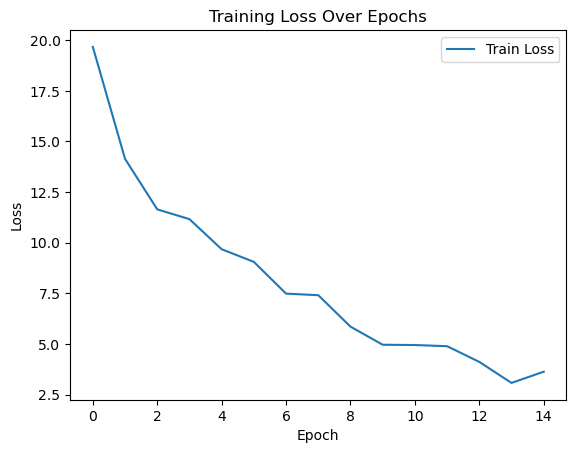

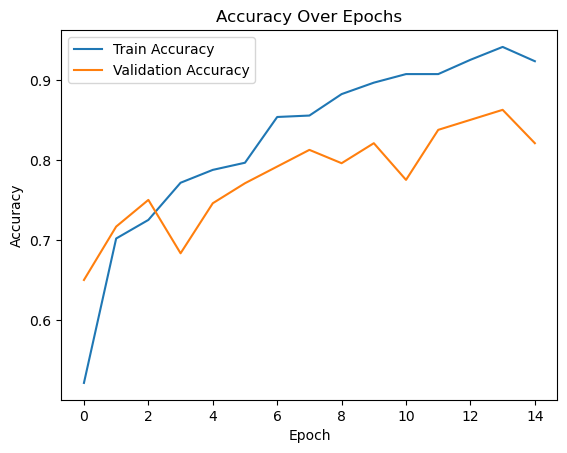

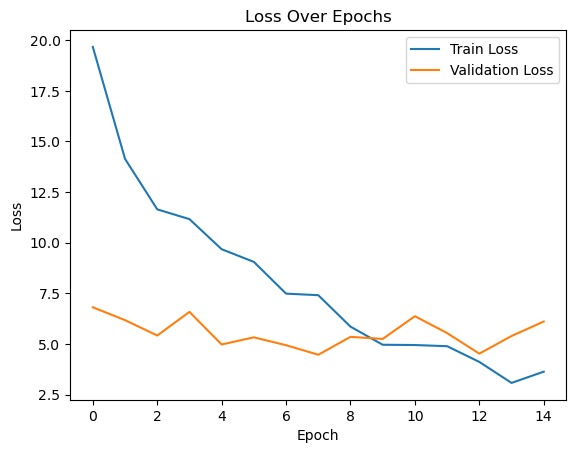

In [7]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='gelu',dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment6:use elu,alpha=1.0,dropout=0.3

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 27.7306, Train Acc: 0.4571, Val Loss: 9.1360, Val Acc: 0.5875
Epoch 2, Train Loss: 15.3962, Train Acc: 0.6661, Val Loss: 7.0096, Val Acc: 0.6750
Epoch 3, Train Loss: 12.9408, Train Acc: 0.7429, Val Loss: 6.0981, Val Acc: 0.7333
Epoch 4, Train Loss: 11.2937, Train Acc: 0.7554, Val Loss: 6.5676, Val Acc: 0.7042
Epoch 5, Train Loss: 10.3767, Train Acc: 0.7839, Val Loss: 7.5144, Val Acc: 0.6792
Epoch 6, Train Loss: 11.4181, Train Acc: 0.7661, Val Loss: 6.3067, Val Acc: 0.7500
Epoch 7, Train Loss: 9.6544, Train Acc: 0.8125, Val Loss: 5.2027, Val Acc: 0.7667
Epoch 8, Train Loss: 8.2476, Train Acc: 0.8357, Val Loss: 5.6184, Val Acc: 0.7750
Epoch 9, Train Loss: 7.4726, Train Acc: 0.8500, Val Loss: 7.3227, Val Acc: 0.7500
Epoch 10, Train Loss: 8.6571, Train Acc: 0.8161, Val Loss: 6.7124, Val Acc: 0.7750
Epoch 11, Train Loss: 6.5525, Train Acc: 0.8625, Val Loss: 6.2207, Val Acc: 0.7917
Epoch 12, Train Loss: 6.

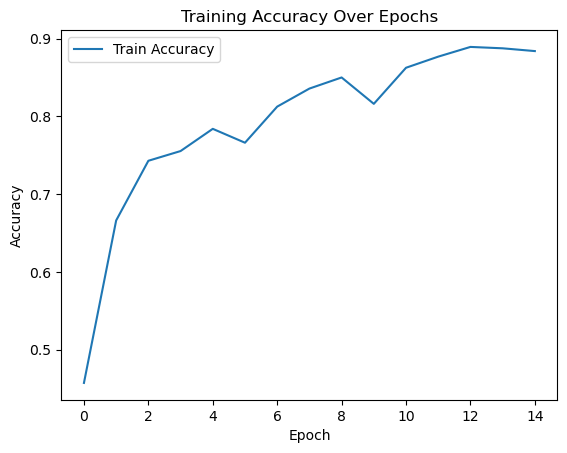

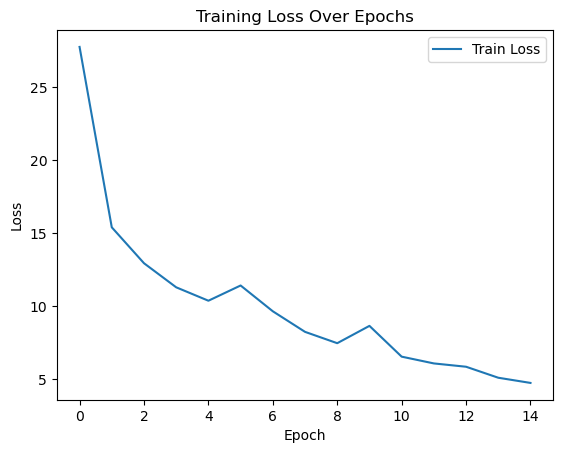

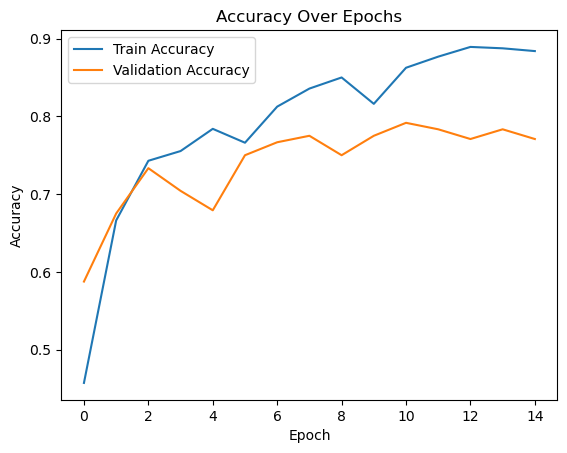

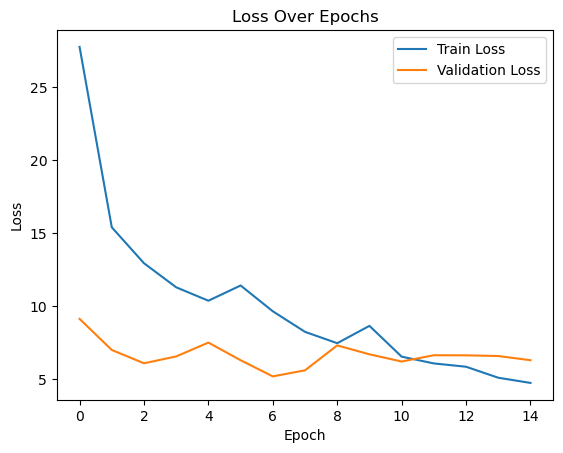

In [8]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='elu',dropout=0.3,alpha=1.0).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment7:use elu,alpha=0.5,dropout=0.3

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 21.0965, Train Acc: 0.5357, Val Loss: 8.1886, Val Acc: 0.6042
Epoch 2, Train Loss: 14.2920, Train Acc: 0.7089, Val Loss: 6.3156, Val Acc: 0.6833
Epoch 3, Train Loss: 10.3489, Train Acc: 0.8125, Val Loss: 7.0541, Val Acc: 0.6583
Epoch 4, Train Loss: 10.5163, Train Acc: 0.7839, Val Loss: 5.9997, Val Acc: 0.7542
Epoch 5, Train Loss: 11.0605, Train Acc: 0.7929, Val Loss: 6.5287, Val Acc: 0.7458
Epoch 6, Train Loss: 8.6654, Train Acc: 0.8143, Val Loss: 5.3956, Val Acc: 0.7500
Epoch 7, Train Loss: 6.6669, Train Acc: 0.8607, Val Loss: 5.6360, Val Acc: 0.7833
Epoch 8, Train Loss: 6.4224, Train Acc: 0.8786, Val Loss: 5.8870, Val Acc: 0.7625
Epoch 9, Train Loss: 6.4447, Train Acc: 0.8768, Val Loss: 5.3636, Val Acc: 0.7917
Epoch 10, Train Loss: 5.2954, Train Acc: 0.8893, Val Loss: 5.1704, Val Acc: 0.7875
Epoch 11, Train Loss: 6.3280, Train Acc: 0.8661, Val Loss: 6.6797, Val Acc: 0.7250
Epoch 12, Train Loss: 5.4

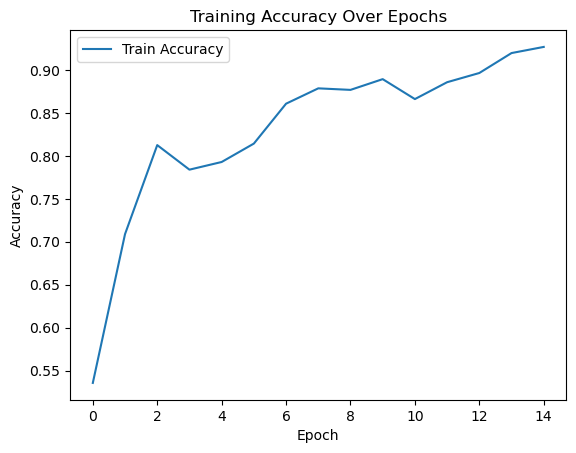

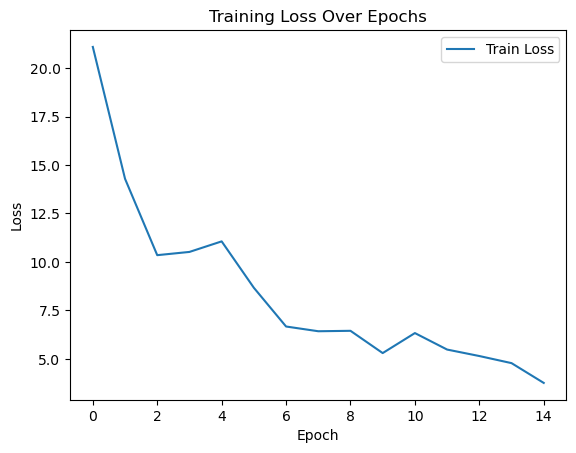

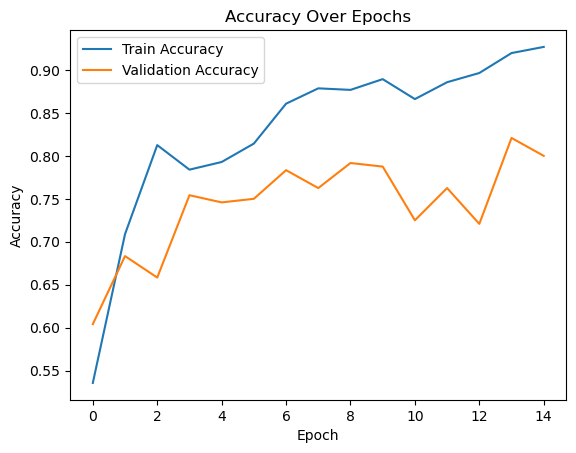

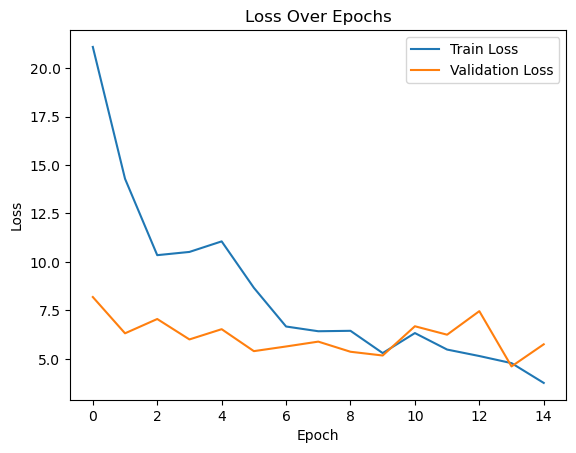

In [9]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='elu',dropout=0.3,alpha=0.5).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment8 :use leakyrelu,negative_slope=0.001，dropout=0.5

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 23.0059, Train Acc: 0.4125, Val Loss: 9.2108, Val Acc: 0.4750
Epoch 2, Train Loss: 16.0024, Train Acc: 0.6732, Val Loss: 6.2031, Val Acc: 0.7042
Epoch 3, Train Loss: 11.1950, Train Acc: 0.7714, Val Loss: 5.3166, Val Acc: 0.7458
Epoch 4, Train Loss: 9.2268, Train Acc: 0.8268, Val Loss: 4.7389, Val Acc: 0.7958
Epoch 5, Train Loss: 7.6645, Train Acc: 0.8518, Val Loss: 4.7105, Val Acc: 0.8000
Epoch 6, Train Loss: 6.9573, Train Acc: 0.8357, Val Loss: 4.6096, Val Acc: 0.7833
Epoch 7, Train Loss: 6.8786, Train Acc: 0.8464, Val Loss: 5.7155, Val Acc: 0.8208
Epoch 8, Train Loss: 6.1196, Train Acc: 0.8732, Val Loss: 3.8579, Val Acc: 0.8500
Epoch 9, Train Loss: 5.0346, Train Acc: 0.8911, Val Loss: 4.5677, Val Acc: 0.8333
Epoch 10, Train Loss: 5.1960, Train Acc: 0.8964, Val Loss: 4.3610, Val Acc: 0.8208
Epoch 11, Train Loss: 5.3187, Train Acc: 0.8911, Val Loss: 3.3439, Val Acc: 0.8375
Epoch 12, Train Loss: 3.949

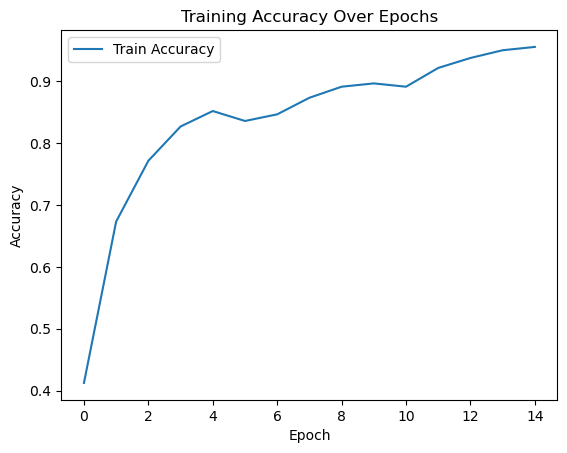

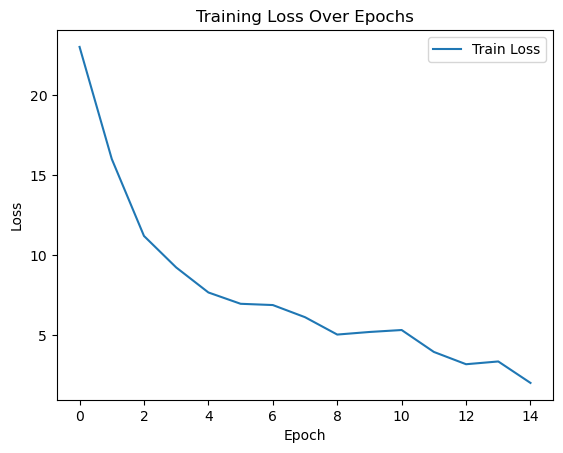

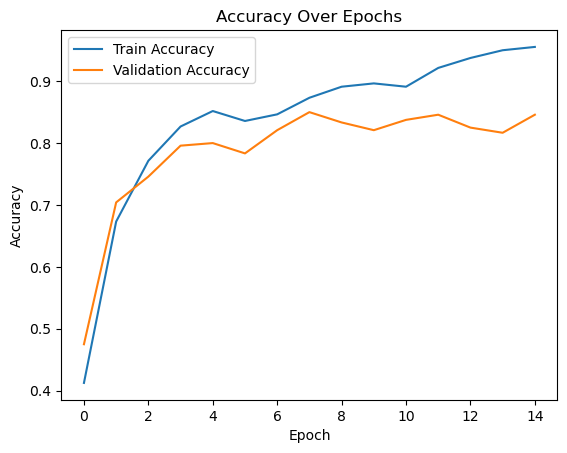

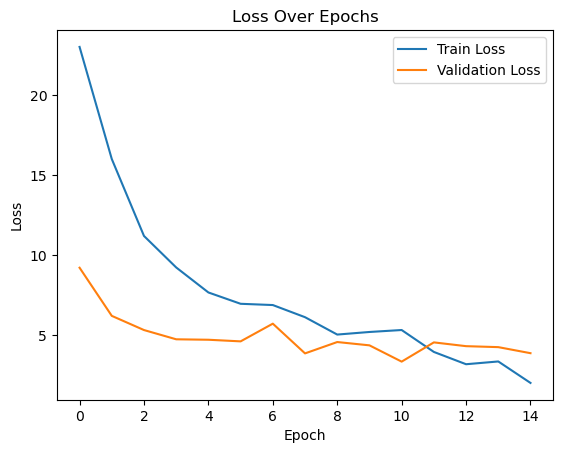

In [10]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='leakyrelu',dropout=0.,negative_slope=0.001).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment10:use elu,alpha=0.5,dropout=0.5

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 24.3817, Train Acc: 0.4375, Val Loss: 8.4771, Val Acc: 0.5583
Epoch 2, Train Loss: 16.6402, Train Acc: 0.6429, Val Loss: 6.4342, Val Acc: 0.7208
Epoch 3, Train Loss: 13.2286, Train Acc: 0.7018, Val Loss: 4.9486, Val Acc: 0.7625
Epoch 4, Train Loss: 11.7694, Train Acc: 0.7607, Val Loss: 6.5865, Val Acc: 0.7167
Epoch 5, Train Loss: 10.1405, Train Acc: 0.7750, Val Loss: 3.6671, Val Acc: 0.8292
Epoch 6, Train Loss: 9.8610, Train Acc: 0.7911, Val Loss: 3.5738, Val Acc: 0.8667
Epoch 7, Train Loss: 8.6099, Train Acc: 0.8161, Val Loss: 3.8803, Val Acc: 0.8458
Epoch 8, Train Loss: 8.2374, Train Acc: 0.8357, Val Loss: 4.3121, Val Acc: 0.8125
Epoch 9, Train Loss: 6.9901, Train Acc: 0.8464, Val Loss: 3.5977, Val Acc: 0.8375
Epoch 10, Train Loss: 6.3081, Train Acc: 0.8696, Val Loss: 4.0869, Val Acc: 0.8292
Epoch 11, Train Loss: 8.2576, Train Acc: 0.8339, Val Loss: 4.6799, Val Acc: 0.8083
Epoch 12, Train Loss: 9.7

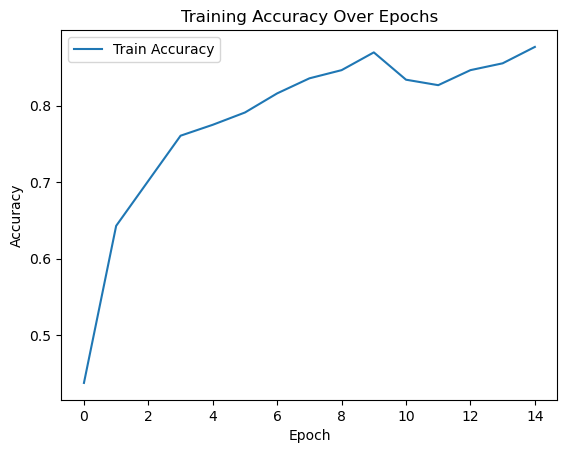

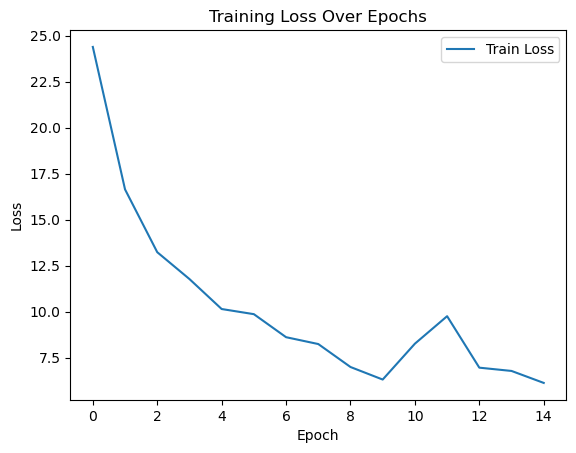

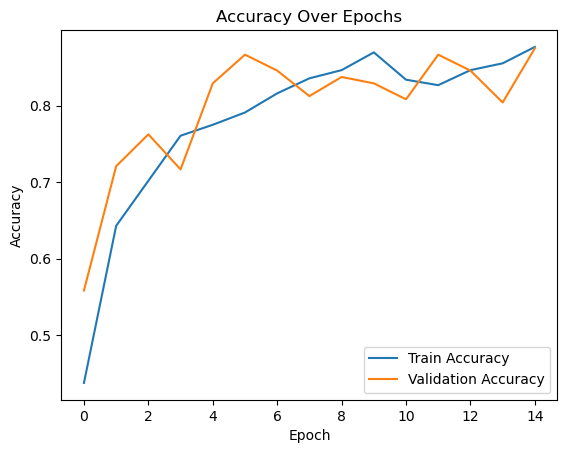

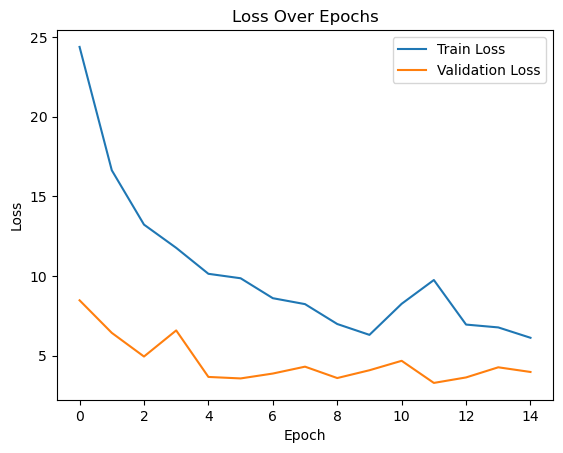

In [11]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='elu',dropout=0.5,alpha=0.5).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

experiment11:use elu,alpha=0.5,dropout=0.4

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 22.7204, Train Acc: 0.4643, Val Loss: 6.2219, Val Acc: 0.6833
Epoch 2, Train Loss: 15.1526, Train Acc: 0.6679, Val Loss: 4.4552, Val Acc: 0.8042
Epoch 3, Train Loss: 10.7363, Train Acc: 0.7607, Val Loss: 5.3749, Val Acc: 0.7375
Epoch 4, Train Loss: 10.5791, Train Acc: 0.7696, Val Loss: 3.6722, Val Acc: 0.8125
Epoch 5, Train Loss: 9.6168, Train Acc: 0.8018, Val Loss: 3.8622, Val Acc: 0.8292
Epoch 6, Train Loss: 9.1440, Train Acc: 0.8054, Val Loss: 4.9965, Val Acc: 0.7542
Epoch 7, Train Loss: 9.5861, Train Acc: 0.8179, Val Loss: 3.9981, Val Acc: 0.8083
Epoch 8, Train Loss: 8.2459, Train Acc: 0.8214, Val Loss: 5.0082, Val Acc: 0.7708
Epoch 9, Train Loss: 7.6434, Train Acc: 0.8393, Val Loss: 4.8320, Val Acc: 0.7958
Epoch 10, Train Loss: 7.5891, Train Acc: 0.8696, Val Loss: 2.9030, Val Acc: 0.8792
Epoch 11, Train Loss: 5.3498, Train Acc: 0.8911, Val Loss: 2.9965, Val Acc: 0.8708
Epoch 12, Train Loss: 5.49

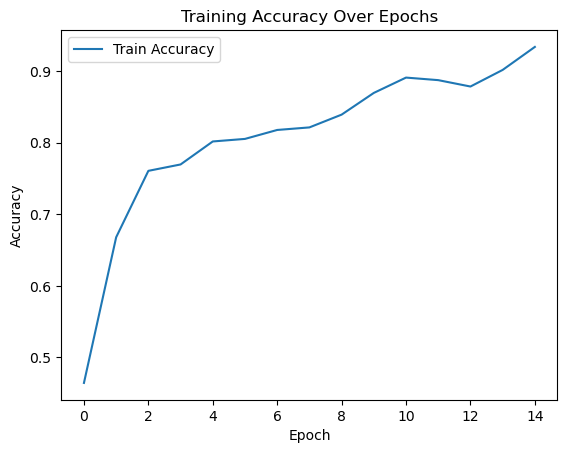

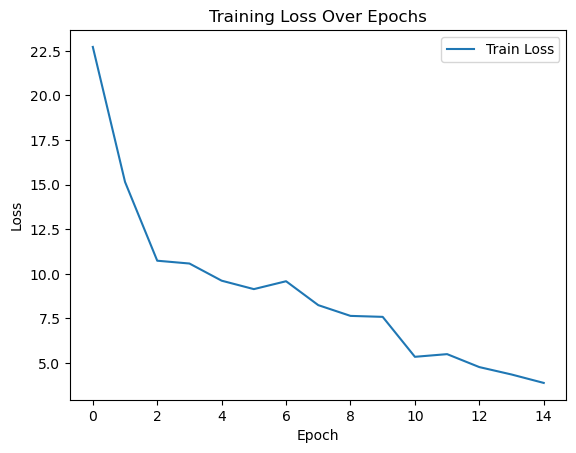

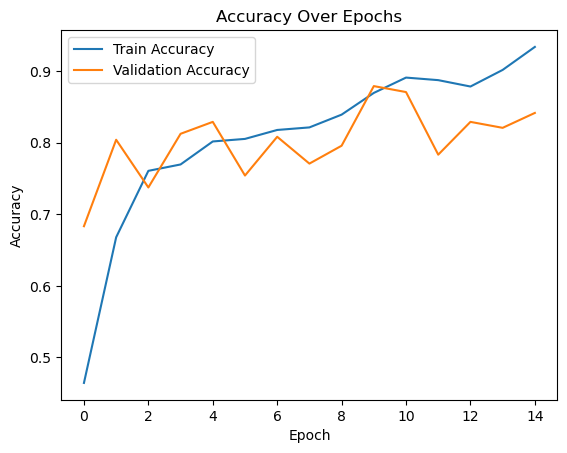

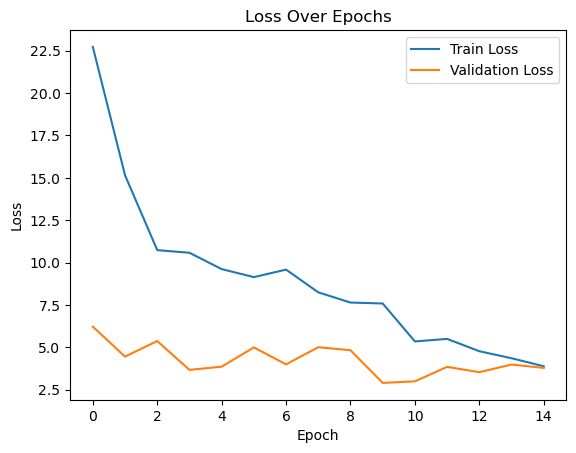

In [1]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

#Define activation select function 
def acti(name, **kwargs):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=kwargs.get("negative_slope", 0.01))
    elif name == "elu":
        return nn.ELU(alpha=kwargs.get("alpha", 1.0))
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self,activation,dropout,**act_kwargs):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            acti(activation, **act_kwargs),                              
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            acti(activation, **act_kwargs), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            acti(activation, **act_kwargs), 
            nn.Dropout(dropout),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN(activation='elu',dropout=0.4,alpha=0.5).to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()